## 生成了已基于 用户和活动的协同过滤结果的参数，用Logistic分类器和SVM对test进行预测

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

In [6]:
#读取训练数据
data_train = pd.read_csv("data_train.csv")
data_train.head()

,invited,user_reco,evt_p_reco,evt_c_reco,user_pop,frnd_infl,evt_pop,interested,not_interested
0,0,-0.000071,0.192949,0.192949,0.000231,0.0,0.000000,0,0
1,0,-0.000071,-0.000038,-0.000038,0.000231,0.0,-0.000012,0,0
2,0,0.019923,-0.000171,-0.000171,0.000231,0.0,-0.000018,1,0
3,0,-0.000071,0.241785,0.241785,0.000231,0.0,0.000032,0,0
4,0,-0.000071,-0.000239,-0.000239,0.000231,0.0,0.000039,0,0


In [7]:
#读取测试数据
data_test = pd.read_csv("data_test.csv")
data_test.head()

,invited,user_reco,evt_p_reco,evt_c_reco,user_pop,frnd_infl,evt_pop
0,0,-0.00009,0.0,0.0,0.000118,0.0,0.000124
1,0,-0.00009,0.0,0.0,0.000118,0.0,0.000002
2,0,-0.00009,0.0,0.0,0.000118,0.0,-0.000002
3,0,-0.00009,0.0,0.0,0.000118,0.0,0.000035
4,0,-0.00009,0.0,0.0,0.000118,0.0,-0.000030


In [8]:
y_train = data_train.interested
X_train = data_train.drop(["interested", "not_interested"], axis=1)

In [16]:
from sklearn.cross_validation import train_test_split

X_train_split, X_train_val, y_train_split, y_train_val = train_test_split(X_train, y_train, random_state=10, test_size=0.3)

In [17]:
X_train_split.shape

(10778, 7)

In [18]:
X_train_val.shape

(4620, 7)

In [37]:
Cs = [1, 10,100,1000, 10000]

lr_cv_l1 = LogisticRegressionCV(Cs,  cv = 5, scoring='neg_log_loss', penalty='l1', solver='saga')
lr_cv_l1.fit(X_train_split, y_train_split)

D:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegressionCV(Cs=[1, 10, 100, 1000, 10000], class_weight=None, cv=5,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l1',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='saga', tol=0.0001, verbose=0)

In [38]:
lr_cv_l1.scores_[1]

array([[-0.58295781, -0.58215643, -0.58205818, -0.58204163, -0.58203418],
       [-0.58314552, -0.58287033, -0.58292747, -0.58293325, -0.58293228],
       [-0.58169518, -0.58022869, -0.58008393, -0.5800637 , -0.58005521],
       [-0.58294681, -0.58275443, -0.58272319, -0.5827012 , -0.58268461],
       [-0.58101767, -0.58145261, -0.58150987, -0.58150785, -0.58150184]])

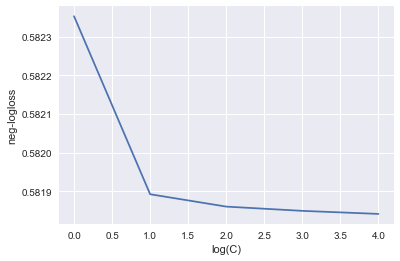

In [39]:
n_Cs = len(Cs)
n_classes = 1
scores =  np.zeros((1,n_Cs))
scores[0][:] = np.mean(lr_cv_l1.scores_[1],axis = 0)
mse_mean = -np.mean(scores, axis = 0)

plt.plot(np.log10(Cs),  mse_mean.reshape(n_Cs,1)) 
plt.xlabel('log(C)')
plt.ylabel('neg-logloss')
plt.show()

再试试L2

In [40]:
Cs = [1, 10,100,1000, 10000]

lr_cv_l2 = LogisticRegressionCV(Cs,  cv = 5, scoring='neg_log_loss', penalty='l2', solver='saga', multi_class='ovr')
lr_cv_l2.fit(X_train_split, y_train_split)

D:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegressionCV(Cs=[1, 10, 100, 1000, 10000], class_weight=None, cv=5,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='saga', tol=0.0001, verbose=0)

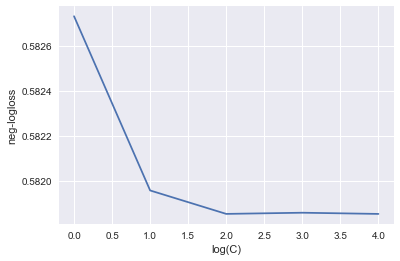

In [41]:
n_Cs = len(Cs)
n_classes = 1
scores =  np.zeros((1,n_Cs))
scores[0][:] = np.mean(lr_cv_l2.scores_[1],axis = 0)
mse_mean = -np.mean(scores, axis = 0)

plt.plot(np.log10(Cs),  mse_mean.reshape(n_Cs,1)) 
plt.xlabel('log(C)')
plt.ylabel('neg-logloss')
plt.show()

可以看到效果差不多，再试试RBF核的SVM

In [43]:
from sklearn.svm import SVC

def fit_grid_point_RBF(C, gamma, X_train_split, y_train_split, X_train_val, y_train_val):
    
    # 在训练集是那个利用SVC训练
    SVC_RBF =  SVC( C = C, kernel='rbf', gamma = gamma)
    SVC_RBF = SVC_RBF.fit(X_train_split, y_train_split)
    
    # 在校验集上返回accuracy
    accuracy = SVC_RBF.score(X_train_val, y_train_val)
    
    print("accuracy: {}".format(accuracy))
    return accuracy

In [45]:
#需要调优的参数
C_s = np.logspace(-2, 2, 5)# logspace(a,b,N)把10的a次方到10的b次方区间分成N份 
gamma_s = np.logspace(-2, 2, 5)  

accuracy_s = []
for i, oneC in enumerate(C_s):
    for j, gamma in enumerate(gamma_s):
        tmp = fit_grid_point_RBF(oneC, gamma, X_train_split, y_train_split, X_train_val, y_train_val)
        accuracy_s.append(tmp)

accuracy: 0.7372294372294372
accuracy: 0.7372294372294372
accuracy: 0.7372294372294372
accuracy: 0.7372294372294372
accuracy: 0.7372294372294372
accuracy: 0.7372294372294372
accuracy: 0.7372294372294372
accuracy: 0.7372294372294372
accuracy: 0.7372294372294372
accuracy: 0.7372294372294372
accuracy: 0.7372294372294372
accuracy: 0.7372294372294372
accuracy: 0.7372294372294372
accuracy: 0.7372294372294372
accuracy: 0.7363636363636363
accuracy: 0.7372294372294372
accuracy: 0.7372294372294372
accuracy: 0.7374458874458875
accuracy: 0.737012987012987
accuracy: 0.7367965367965368
accuracy: 0.7372294372294372
accuracy: 0.7374458874458875
accuracy: 0.7374458874458875
accuracy: 0.7361471861471861
accuracy: 0.7361471861471861


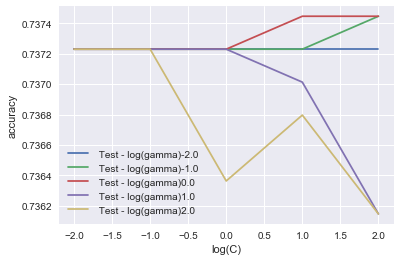

In [46]:
accuracy_s1 =np.array(accuracy_s).reshape(len(C_s),len(gamma_s))
x_axis = np.log10(C_s)
for j, gamma in enumerate(gamma_s):
    plt.plot(x_axis, np.array(accuracy_s1[:,j]), label = ' Test - log(gamma)' + str(np.log10(gamma)))

plt.legend()
plt.xlabel( 'log(C)' )                                                                                                      
plt.ylabel( 'accuracy' )
plt.savefig('RBF_SVM.png' )

plt.show()

In [49]:
# 用gammma=0.0 和 logC=1.0再次对全训练集进行训练
SVC_whole = SVC(C=10, gamma=1,  kernel='rbf')
SVC_whole.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [50]:
test_interesting = SVC_whole.predict(data_test)
test_interesting

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

需要再把test里面的user_id取出来

In [52]:
test = pd.read_csv("test.csv")
test.head()

,user,event,invited,timestamp
0,1776192,2877501688,0,2012-11-30 11:39:01.230000+00:00
1,1776192,3025444328,0,2012-11-30 11:39:01.230000+00:00
2,1776192,4078218285,0,2012-11-30 11:39:01.230000+00:00
3,1776192,1024025121,0,2012-11-30 11:39:01.230000+00:00
4,1776192,2972428928,0,2012-11-30 11:39:21.985000+00:00


In [55]:
final_predict = pd.DataFrame({
    'user' : test.user.values,
    'event' : test.event.values,
    'interested' : test_interesting
})
final_predict.head()

,event,interested,user
0,2877501688,0,1776192
1,3025444328,0,1776192
2,4078218285,0,1776192
3,1024025121,0,1776192
4,2972428928,0,1776192


In [56]:
final_predict.to_csv("final_predit_svc.csv")